# Hands-on

## Choropleths in Python

```{important}
This is an adapted version, with a bit less content and detail, of the chapter on choropleth mapping by Rey, Arribas-Bel and Wolf (*in progress*) {cite}`reyABwolf`. Check out the full chapter, available for free at:

> [https://geographicdata.science/book/notebooks/05_choropleth.html](https://geographicdata.science/book/notebooks/05_choropleth.html)
```

In this session, we will build on all we have learnt so far about loading and manipulating (spatial) data and apply it to one of the most commonly used forms of spatial analysis: choropleths. Remember these are maps that display the spatial distribution of a variable encoded in a color scheme, also called *palette*. Although there are many ways in which you can convert the values of a variable into a specific color, we will focus in this context only on a handful of them, in particular:

* Unique values
* Equal interval
* Quantiles
* Fisher-Jenks

Before all this mapping fun, let us get the importing of libraries and data loading out of the way:

In [1]:
%matplotlib inline

import geopandas
from pysal.lib import examples
import seaborn as sns
import pandas as pd
from pysal.viz import mapclassify
import numpy as np
import matplotlib.pyplot as plt

## Data

To mirror the [original chapter](https://geographicdata.science/book/notebooks/05_choropleth.html) this section is based on, we will use the same dataset: the [Mexico GDP per capita dataset](https://geographicdata.science/book/data/mexico/README.html), which we can access as a PySAL example dataset.

```{note}
You can read more about PySAL example datasets [here](https://pysal.org/libpysal/notebooks/examples.html)
```

We can get a short explanation of the dataset through the `explain` method:

In [2]:
examples.explain("mexico")

mexico

Decennial per capita incomes of Mexican states 1940-2000
--------------------------------------------------------

* mexico.csv: attribute data. (n=32, k=13)
* mexico.gal: spatial weights in GAL format.
* mexicojoin.shp: Polygon shapefile. (n=32)

Data used in Rey, S.J. and M.L. Sastre Gutierrez. (2010) "Interregional inequality dynamics in Mexico." Spatial Economic Analysis, 5: 277-298.



Now, to download it from its remote location, we can use `load_example`:

In [3]:
mx = examples.load_example("mexico")

This will download the data and place it on your home directory. We can inspect the directory where it is stored:

In [4]:
mx.get_file_list()

['/opt/conda/lib/python3.8/site-packages/libpysal/examples/mexico/mexicojoin.shx',
 '/opt/conda/lib/python3.8/site-packages/libpysal/examples/mexico/README.md',
 '/opt/conda/lib/python3.8/site-packages/libpysal/examples/mexico/mexico.gal',
 '/opt/conda/lib/python3.8/site-packages/libpysal/examples/mexico/mexico.csv',
 '/opt/conda/lib/python3.8/site-packages/libpysal/examples/mexico/mexicojoin.shp',
 '/opt/conda/lib/python3.8/site-packages/libpysal/examples/mexico/mexicojoin.prj',
 '/opt/conda/lib/python3.8/site-packages/libpysal/examples/mexico/mexicojoin.dbf']

For this section, we will read the ESRI shapefile, which we can do by pointing `geopandas.read_file` to the `.shp` file. The utility function `get_path` makes it a bit easier for us:

In [5]:
db = geopandas.read_file(examples.get_path("mexicojoin.shp"))

And, from now on, `db` is a table as we are used to so far in this course:

In [6]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   POLY_ID     32 non-null     int64   
 1   AREA        32 non-null     float64 
 2   CODE        32 non-null     object  
 3   NAME        32 non-null     object  
 4   PERIMETER   32 non-null     float64 
 5   ACRES       32 non-null     float64 
 6   HECTARES    32 non-null     float64 
 7   PCGDP1940   32 non-null     float64 
 8   PCGDP1950   32 non-null     float64 
 9   PCGDP1960   32 non-null     float64 
 10  PCGDP1970   32 non-null     float64 
 11  PCGDP1980   32 non-null     float64 
 12  PCGDP1990   32 non-null     float64 
 13  PCGDP2000   32 non-null     float64 
 14  HANSON03    32 non-null     float64 
 15  HANSON98    32 non-null     float64 
 16  ESQUIVEL99  32 non-null     float64 
 17  INEGI       32 non-null     float64 
 18  INEGI2      32 non-null     float64 
 19  MA

The data however does not include a CRS:

In [7]:
db.crs

To be able to add baselayers, we need to specify one. Looking at the details and the original reference, we find the data are expressed in longitude and latitude, so the CRS we can use is `EPSG:4326`. Let's add it to `db`:

In [8]:
db.crs = "EPSG:4326"
db.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we are fully ready to map!

## Choropleths

### Unique values

A choropleth for categorical variables simply assigns a different color to every potential value in the series. The main requirement in this case is then for the color scheme to reflect the fact that different values are not ordered or follow a particular scale.

In Python, creating categorical choropleths is possible with one line of code. To demonstrate this, we can plot the Mexican states and the region each belongs to based on the Mexican Statistics Institute (coded in our table as the `INEGI` variable):

<AxesSubplot:>

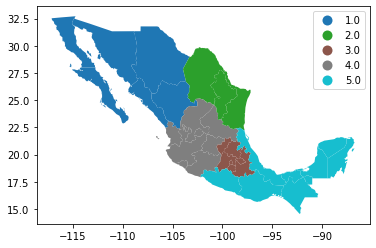

In [9]:
db.plot(
    column="INEGI", 
    categorical=True, 
    legend=True
)

Let us stop for a second in a few crucial aspects:

* Note how we are using the same approach as for basic maps, the command `plot`, but we now need to add the argument `column` to specify which column in particular is to be represented.
* Since the variable is categorical we need to make that explicit by setting the argument `categorical` to `True`.
* As an optional argument, we can set `legend` to `True` and the resulting figure will include a legend with the names of all the values in the map.
* Unless we specify a different colormap, the selected one respects the categorical nature of the data by not implying a gradient or scale but a qualitative structure.

### Equal interval

If, instead of categorical variables, we want to display the geographical distribution of a continuous phenomenon, we need to select a way to encode each value into a color. One potential solution is applying what is usually called "equal intervals". The intuition of this method is to split the *range* of the distribution, the difference between the minimum and maximum value, into equally large segments and to assign a different color to each of them according to a palette that reflects the fact that values are ordered.

Creating the choropleth is relatively straightforward in Python. For example, to create an equal interval on the GDP per capita in 2000 (`PCGDP2000`), we can run a similar command as above:

<AxesSubplot:>

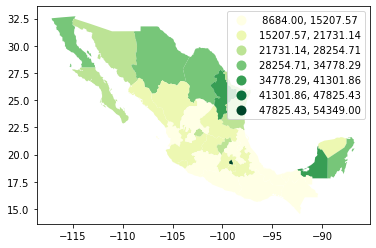

In [10]:
db.plot(
    column="PCGDP2000", 
    scheme="equal_interval", 
    k=7,
    cmap="YlGn",
    legend=True
)

Pay attention to the key differences:

* Instead of specifyig `categorical` as `True`, we replace it by the argument `scheme`, which we will use for all choropleths that require a continuous classification scheme. In this case, we set it to `equal_interval`.
* As above, we set the number of colors to 7. Note that we need not pass the bins we calculated above, the plotting method does it itself under the hood for us.
* As optional arguments, we can change the colormap to a yellow to green gradient, which is one of the recommended ones by [ColorBrewer](http://colorbrewer2.org/) for a sequential palette. 

Now, let's dig a bit deeper into the classification, and how exactly we are encoding values into colors. Each segment, also called bins or buckets, can also be calculated using the library `mapclassify` from the `PySAL` family:

In [11]:
classi = mapclassify.EqualInterval(db["PCGDP2000"], k=7)
classi

EqualInterval               

      Interval         Count
----------------------------
[ 8684.00, 15207.57] |    10
(15207.57, 21731.14] |    10
(21731.14, 28254.71] |     5
(28254.71, 34778.29] |     4
(34778.29, 41301.86] |     2
(41301.86, 47825.43] |     0
(47825.43, 54349.00] |     1

The only additional argument to pass to `Equal_Interval`, other than the actual variable we would like to classify is the number of segments we want to create, `k`, which we are arbitrarily setting to seven in this case. This will be the number of colors that will be plotted on the map so, although having several can give more detail, at some point the marginal value of an additional one is fairly limited, given the ability of the brain to tell any differences.

Once we have classified the variable, we can check the actual break points where values stop being in one class and become part of the next one:

In [12]:
classi.bins

array([15207.57142857, 21731.14285714, 28254.71428571, 34778.28571429,
       41301.85714286, 47825.42857143, 54349.        ])

The array of breaking points above implies that any value in the variable below 15,207.57 will get the first color in the gradient when mapped, values between 15,207.57 and 21,731.14 the next one, and so on.

The key characteristic in equal interval maps is that the bins are allocated based on the magnitude on the values, irrespective of how many obervations fall into each bin as a result of it. In highly skewed distributions, this can result in bins with a large number of observations, while others only have a handful of outliers. This can be seen in the summary table printed out above, where ten states are in the first group, but only one of them belong to the one with highest values. This can also be represented visually with a kernel density plot where the break points are included as well:

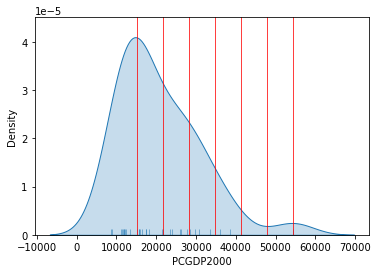

In [13]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(db["PCGDP2000"], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(db["PCGDP2000"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

Technically speaking, the figure is created by overlaying a KDE plot with vertical bars for each of the break points. This makes much more explicit the issue highlighed by which the first bin contains a large amount of observations while the one with top values only encompasses a handful of them.

### Quantiles

One solution to obtain a more balanced classification scheme is using quantiles. This, by definition, assigns the same amount of values to each bin: the entire series is laid out in order and break points are assigned in a way that leaves exactly the same amount of observations between each of them. This "observation-based" approach contrasts with the "value-based" method of equal intervals and, although it can obscure the magnitude of extreme values, it can be more informative in cases with skewed distributions.

The code required to create the choropleth mirrors that needed above for equal intervals:

<AxesSubplot:>

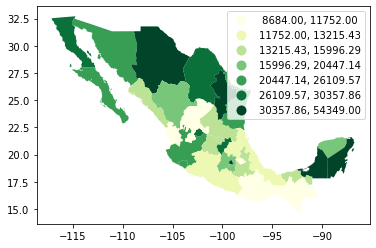

In [14]:
db.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=True
)

Note how, in this case, the amount of polygons in each color is by definition much more balanced (almost equal in fact, except for rounding differences). This obscures outlier values, which get blurred by significantly smaller values in the same group, but allows to get more detail in the "most populated" part of the distribution, where instead of only white polygons, we can now discern more variability.

To get further insight into the quantile classification, let's calculate it with `mapclassify`:

In [15]:
classi = mapclassify.Quantiles(db["PCGDP2000"], k=7)
classi

Quantiles                   

      Interval         Count
----------------------------
[ 8684.00, 11752.00] |     5
(11752.00, 13215.43] |     4
(13215.43, 15996.29] |     5
(15996.29, 20447.14] |     4
(20447.14, 26109.57] |     5
(26109.57, 30357.86] |     4
(30357.86, 54349.00] |     5

And, similarly, the bins can also be inspected:

In [16]:
classi.bins

array([11752.        , 13215.42857143, 15996.28571429, 20447.14285714,
       26109.57142857, 30357.85714286, 54349.        ])

The visualization of the distribution can be generated in a similar way as well:

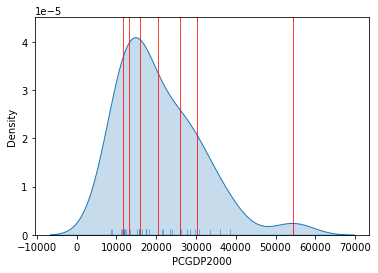

In [17]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(db["PCGDP2000"], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(db["PCGDP2000"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

### Fisher-Jenks

Equal interval and quantiles are only two examples of very many classification schemes to encode values into colors. Although not all of them are integrated into `geopandas`, `PySAL` includes several other classification schemes (for a detailed list, have a look at this [link](https://pysal.org/mapclassify/notebooks/01_maximum_breaks.html)). As an example of a more sophisticated one, let us create a Fisher-Jenks choropleth:

<AxesSubplot:>

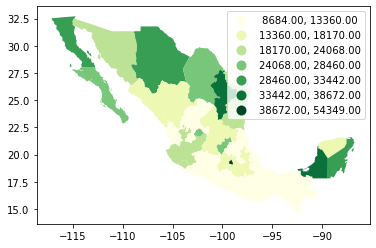

In [18]:
db.plot(
    column="PCGDP2000", 
    scheme="fisher_jenks", 
    k=7,
    cmap="YlGn",
    legend=True
)

The same classification can be obtained with a similar approach as before:

In [19]:
classi = mapclassify.FisherJenks(db["PCGDP2000"], k=7)
classi

FisherJenks                 

      Interval         Count
----------------------------
[ 8684.00, 13360.00] |    10
(13360.00, 18170.00] |     8
(18170.00, 24068.00] |     4
(24068.00, 28460.00] |     4
(28460.00, 33442.00] |     3
(33442.00, 38672.00] |     2
(38672.00, 54349.00] |     1

This methodology aims at minimizing the variance *within* each bin while maximizing that *between* different classes.

In [20]:
classi.bins

array([13360., 18170., 24068., 28460., 33442., 38672., 54349.])

Graphically, we can see how the break points are not equally spaced but are adapting to obtain an optimal grouping of observations:

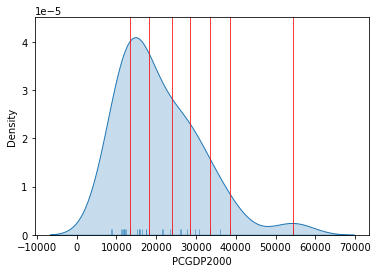

In [21]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(db["PCGDP2000"], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(db["PCGDP2000"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

For example, the bin with highest values covers a much wider span that the one with lowest, because there are fewer states in that value range.

## Zooming into the map

### Zoom into full map

A general map of an entire region, or urban area, can sometimes obscure local patterns because they happen at a much smaller scale that cannot be perceived in the global view. One way to solve this is by providing a focus of a smaller part of the map in a separate figure. Although there are many ways to do this in Python, the most straightforward one is to reset the limits of the axes to center them in the area of interest.

As an example, let us consider the quantile map produced above:

<AxesSubplot:>

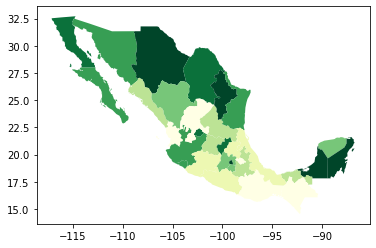

In [22]:
db.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=False
)

If we want to focus around the capital, Mexico DF, the first step involves realising that such area of the map (the little dark green polygon in the SE centre of the map), falls within the coordinates of -102W/-97W, and 18N/21N, roughly speaking. To display a zoom map into that area, we can do as follows:

(-102.0, -97.0)

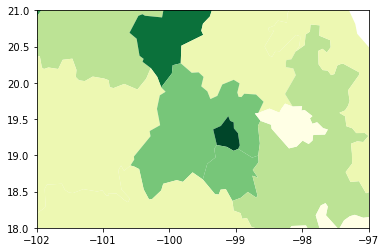

In [23]:
# Setup the figure
f, ax = plt.subplots(1)
# Draw the choropleth
db.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=False,
    ax=ax
)
# Redimensionate X and Y axes to desired bounds
ax.set_ylim(18, 21)
ax.set_xlim(-102, -97)

### Partial map

The approach above is straightforward, but not necessarily the most efficient one: not that, to generate a map of a potentially very small area, we effectively draw the entire (potentially very large) map, and discard everything except the section we want. This is not straightforward to notice at first sight, but what Python is doing in the code cell above is plottin the entire `db` object, and only then focusing the figure on the X and Y ranges specified in `set_xlim`/`set_ylim`.

Sometimes, this is required. For example, if we want to retain the same coloring used for the national map, but focus on the region around Mexico DF, this approach is the easiest one.

However, sometimes, we only need to plot the _geographical features_ within a given range, and we either don't need to keep the national coloring (e.g. we are using a single color), or we want a classification performed _only_ with the features in the region.

For these cases, it is computationally more efficient to select the data we want to plot first, and then display them through `plot`. For this, we can rely on the `cx` operator:

<AxesSubplot:>

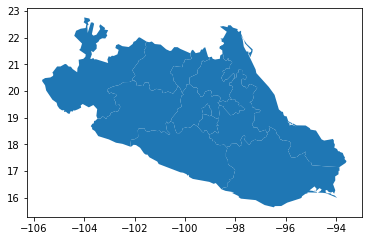

In [24]:
subset = db.cx[-102:-97, 18:21]
subset.plot()

We query the range of spatial coordinates similarly to how we query indices with `loc`. Note however the result includes full geographic features, and hence the polygons with at least some area within the range are included fully. This results in a larger range than originally specified.

This approach is a "spatial slice". If you remember when we saw {ref}`non-spatial slices <lab_B:slices>` (enabled by the `loc` operator), this is a similar approach but our selection criteria, instead of subsetting by indices of the table, are based on the spatial coordinates of the data represented in the table.

Since the result is a `GeoDataFrame` itself, we can create a choropleth that is based only on the data in the subset:

<AxesSubplot:>

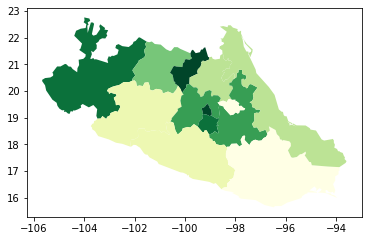

In [25]:
subset.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=False
)